In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 102.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.2 MB/s eta 0:00:00


In [ ]:
# Import the necessary libraries
from transformers import BertTokenizer, TFBertModel,TFBertForSequenceClassification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tngarg","key":"6677e6e70a6e2e5722e8fea7b401f7f7"}'}

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d mrmorj/hate-speech-and-offensive-language-dataset

  0% 0.00/1.01M [00:00<?, ?B/s]
100% 1.01M/1.01M [00:00<00:00, 46.0MB/s]


In [ ]:
!unzip hate-speech-and-offensive-language-dataset.zip

Archive:  hate-speech-and-offensive-language-dataset.zip
  inflating: labeled_data.csv        


In [ ]:
dataset = pd.read_csv('labeled_data.csv')
dataset.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
dataset['class'].unique()

array([2, 1, 0])

In [ ]:
dataset.shape

(24783, 7)

In [ ]:
from sklearn.model_selection import train_test_split
train_data,test_data = train_test_split(dataset, test_size=0.2)
train_data_1, val_data = train_test_split(train_data, test_size=0.2)

In [ ]:
# Prepare the data: preprocess using Bert Tokenizer and add special tokens,eg[cls] and [sep] and padding sequences to make fixed length
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Prepare the training model
# Tokenize the text data
train_encodings = tokenizer(train_data['tweet'].tolist(), truncation=True, padding=True) # tolist() to convert a pandas series to a list
# Train_dataset : Tensor with input_ids and attention_mask as 2 ids for the dictionary passed from train_encoding
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), list(train_data['class'])))

In [ ]:
# fine tuning pretrained Bert model on IMDB dataset
#fine tuning : This involves adding a classification layer on top of the pre-trained BERT model,
# and adjusting the model parameters for your specific task.
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

tf.data.Dataset.from_tensor_slices() function is used to create a TensorFlow Dataset from the preprocessed training, validation, and test data. Specifically, the function creates a dataset where each element corresponds to a single sample in the dataset, along with its corresponding label.

In [ ]:
val_encodings = tokenizer(val_data['tweet'].tolist(), truncation=True, padding=True)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), list(val_data['class'])))

In [ ]:
history = model.fit(train_dataset.shuffle(1000).batch(10), epochs=2, batch_size=10, validation_data=val_dataset.batch(10))

Epoch 1/2
1983/1983 [==============================] - 2053s 1s/step - loss: 0.2970 - accuracy: 0.8965 - val_loss: 0.2065 - val_accuracy: 0.9188
Epoch 2/2
1983/1983 [==============================] - 1991s 1s/step - loss: 0.2137 - accuracy: 0.9236 - val_loss: 0.1491 - val_accuracy: 0.9443


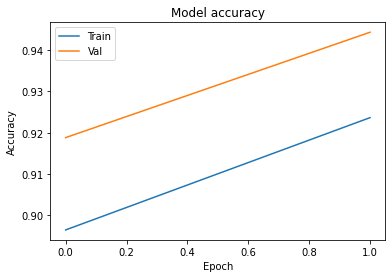

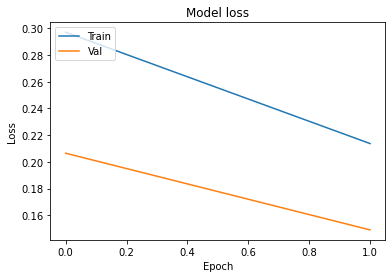

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()






In [ ]:
test_encodings = tokenizer(test_data['tweet'].tolist(), truncation=True, padding=True)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), list(test_data['class'])))

In [ ]:
# evaluating the model
test_loss, test_acc = model.evaluate(test_dataset.batch(10))
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


496/496 [==============================] - 211s 417ms/step - loss: 0.2319 - accuracy: 0.9189
Test loss: 0.2318548709154129
Test accuracy: 0.918902575969696


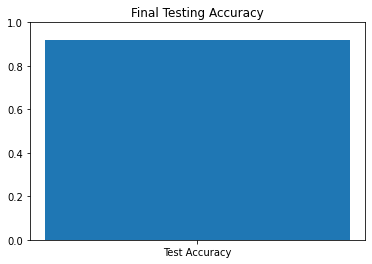

In [ ]:
plt.bar(['Test Accuracy'], [test_acc])
plt.ylim([0, 1])
plt.title('Final Testing Accuracy')
plt.show()

In [ ]:
import os
os.makedirs("path/to/bert_model_file1")
model.save_pretrained("path/to/bert_model_file1")

In [ ]:
# model = .from_pretrained("path/to/bert_model_file1")

In [ ]:
#make predictions
texts = ['This movie was great!', 'This movie was terrible.']
# Tokenize the texts
encodings = tokenizer(texts, truncation=True, padding=True,return_tensors='tf')
predictions = model.predict(encodings)


ValueError: ignored